In [ ]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m
import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

# make plt plot inline
%matplotlib inline

1. conda install pip spyder pyqtgraph
2. pip install spinmob mcphysics imageio sounddevice

## Loading in the data

In [ ]:
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'

am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + 'lead2_extended.chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_1.chn')

channels = am_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 

## Creating the energy scale

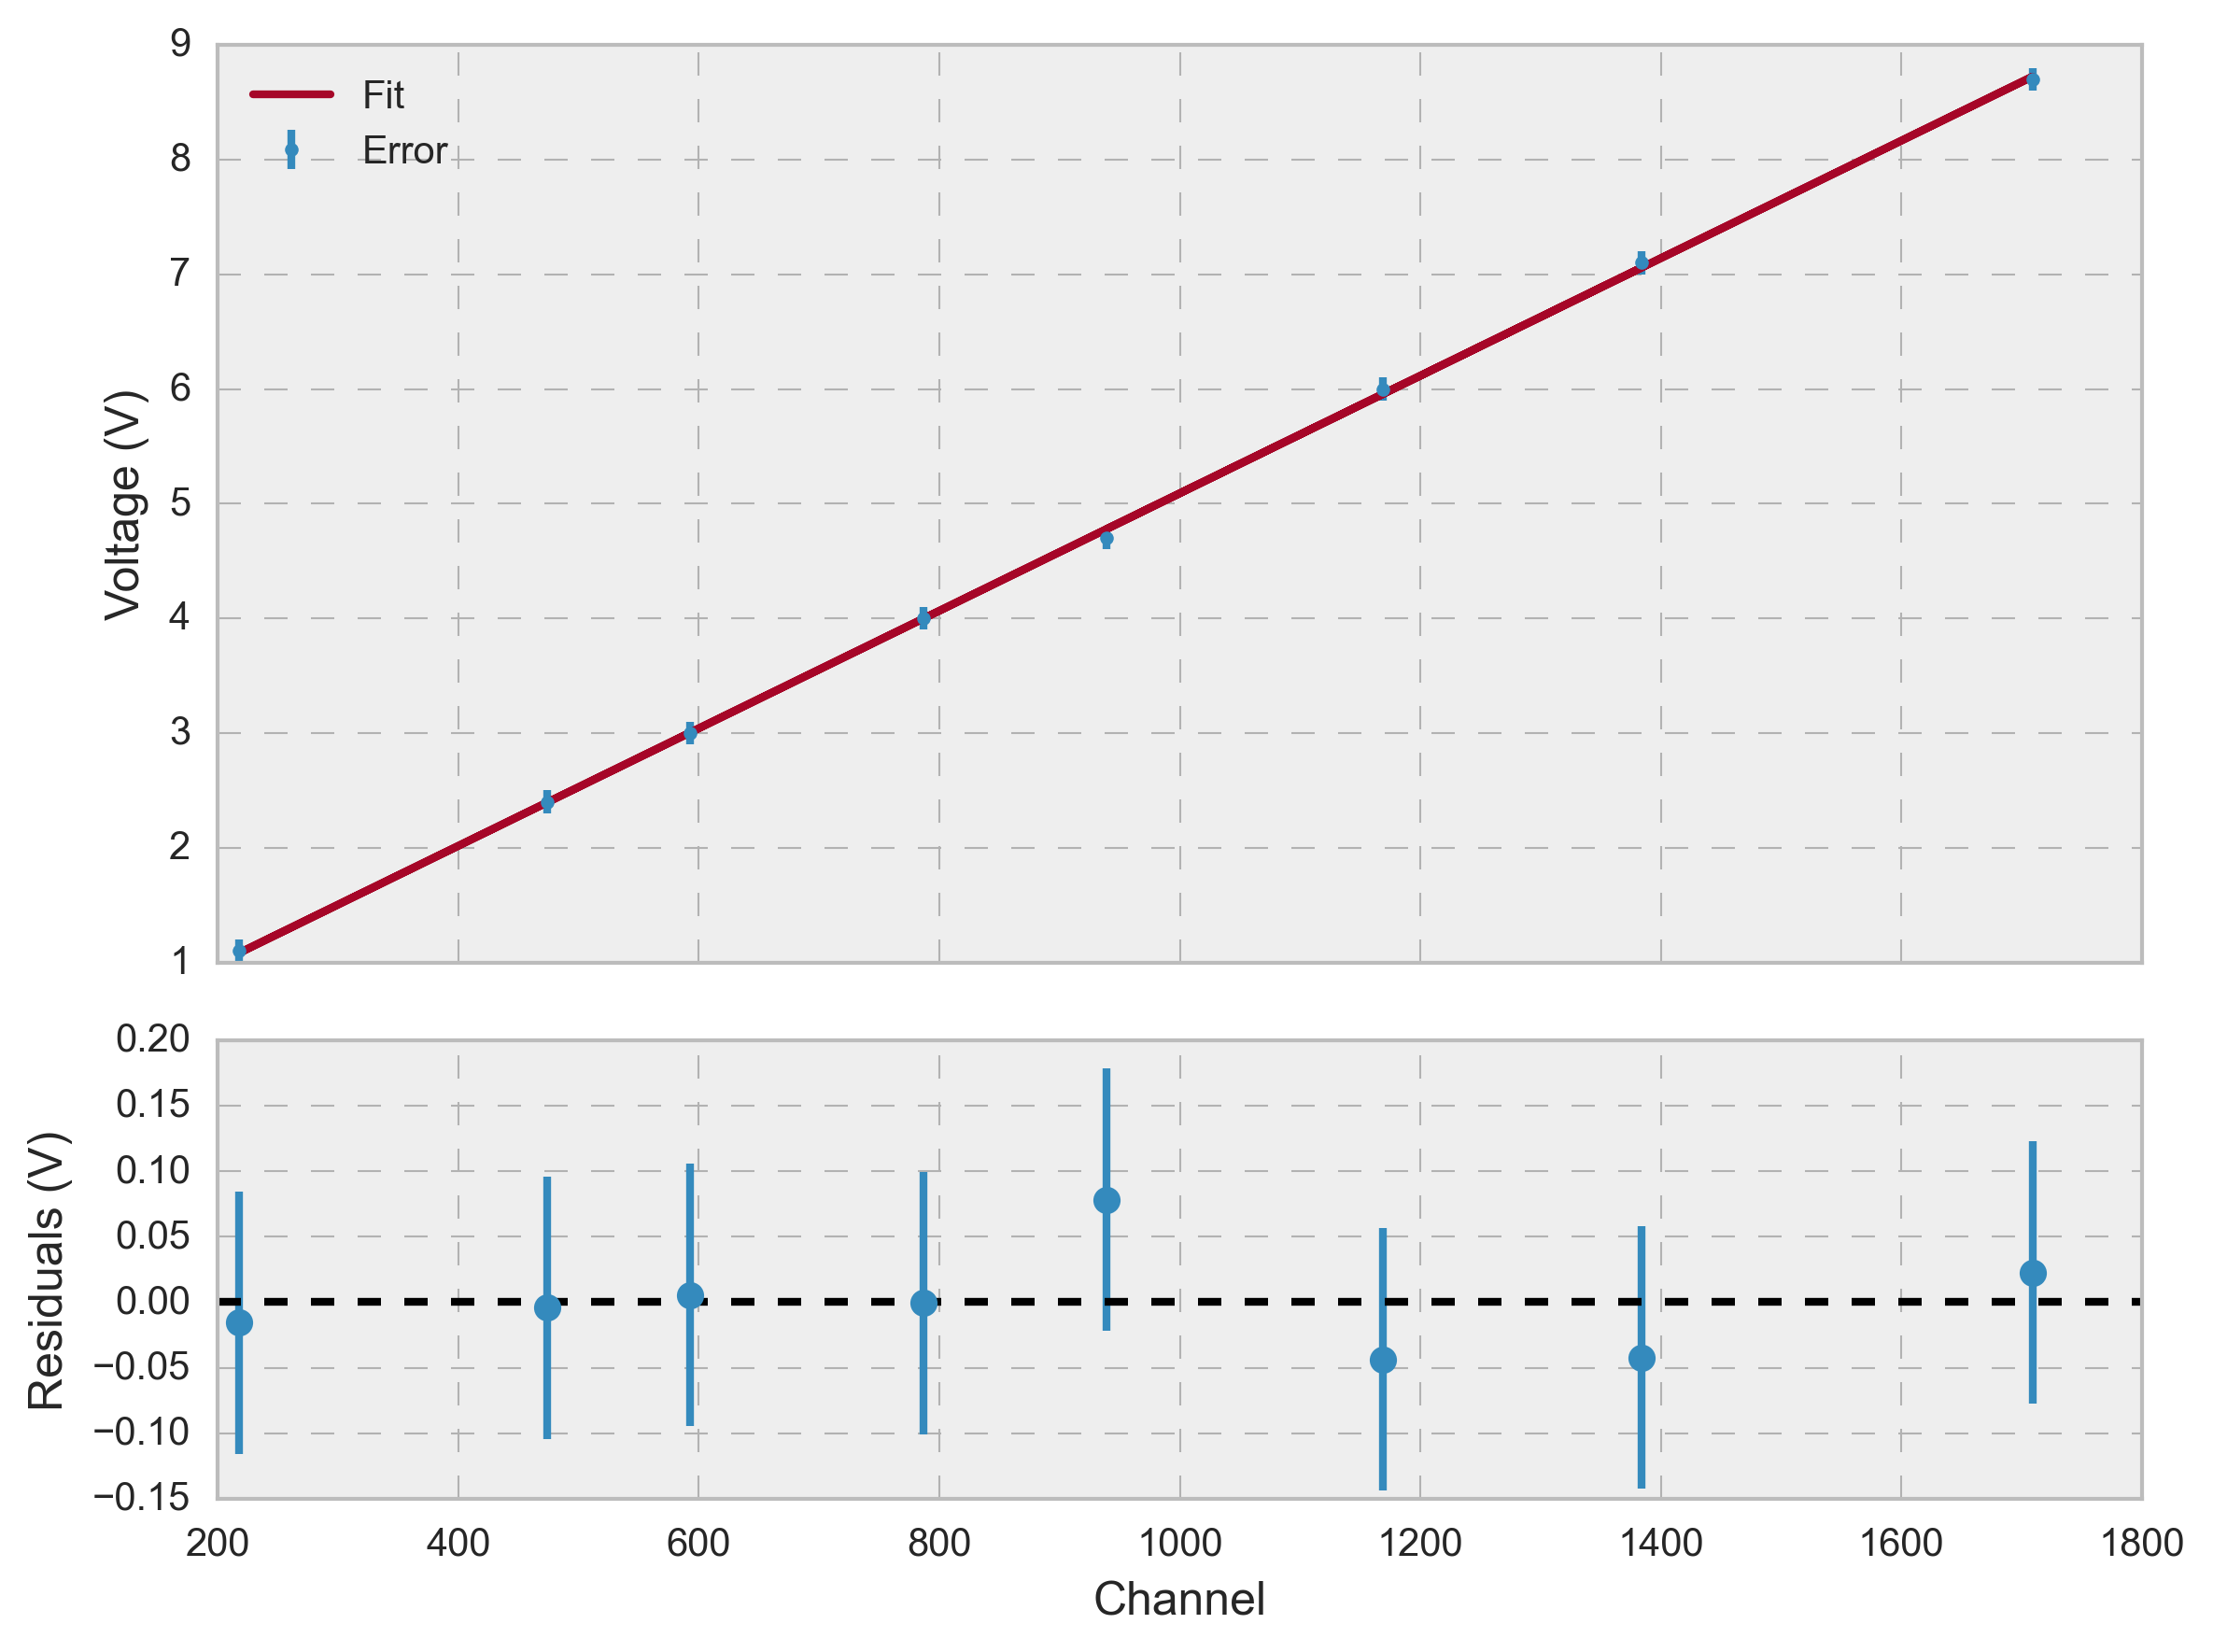

In [226]:
def line(channels, m, b):
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# voltage calibrations we took with the pulser
pulser_voltages = np.array([4.7, 8.7, 2.4, 1.1, 3, 4, 6, 7.1])
pulser_channels = np.array([939, 1709, 474, 218, 593, 787, 1169, 1384])

# fit the calibration data
popt, pcov = opt.curve_fit(line, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt

# plot the fit and residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi = 300, gridspec_kw={'height_ratios': [2, 1]})

# Main plot
ax1.errorbar(pulser_channels, pulser_voltages, yerr=0.1, fmt='.', label='Error')
ax1.plot(pulser_channels, line(pulser_channels, m, b), label='Fit')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc = 'upper left')

# Residuals plot
ax2.errorbar(pulser_channels, line(pulser_channels, m, b) - pulser_voltages, yerr=0.1, fmt='o')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Residuals (V)')

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/calibration.pdf', bbox_inches='tight')
plt.show()

### Fitting the americium energy

In [115]:
# get the calibration function
calibration = interp1d(line(channels, m, b), channels)

# fit a straight line to the calibration data
calibration_fit = np.poly1d(np.polyfit(pulser_channels, pulser_voltages, 1))

# convert the channels to voltages
voltages = calibration_fit(channels)

# we know that energy and voltage scale linearly, and know the energy of am_peak bin
# getting the location of the am peak bin 

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

popt, pcov = opt.curve_fit(gaussian, channels, am_counts, p0=[np.max(am_counts), channels[am_peak], 0.5])

amplitude, mean, sigma = popt
mean_error = np.sqrt(pcov[1, 1])  # Standard error of the mean

# Print the results
print(f"Peak position: {mean:.5f} ± {mean_error:.5f}")

# converting mean and error to energy
am_peak_energy = 5.486 # MeV
energy = am_peak_energy * voltages / calibration_fit(mean)
energy_err = am_peak_energy * calibration_fit(mean) * mean_error

print(f"Peak position in energy:  ± {energy_err:.5f} MeV")

# getting Poisson err for the counts
am_counts_err = np.sqrt(am_counts[am_peak])
pb_counts_err = np.sqrt(pb_counts)

Peak position: 469.85302 ± 0.01058
Peak position in energy:  ± 0.13781 MeV


## Identifying lead peaks

In [116]:
# finding the peaks in the lead spectrum. note: highest peak is from us leaving the pulser on

# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 500:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print(f'The peaks are at channels: {peaks}, corresponding to energies: {energy[peaks]} +- {energy_err} MeV.')

# uncertainties?

The peaks are at channels: [521, 751], corresponding to energies: [6.09133923 8.81345545] +- 0.13781179323964252 MeV.


## Making the multipanel

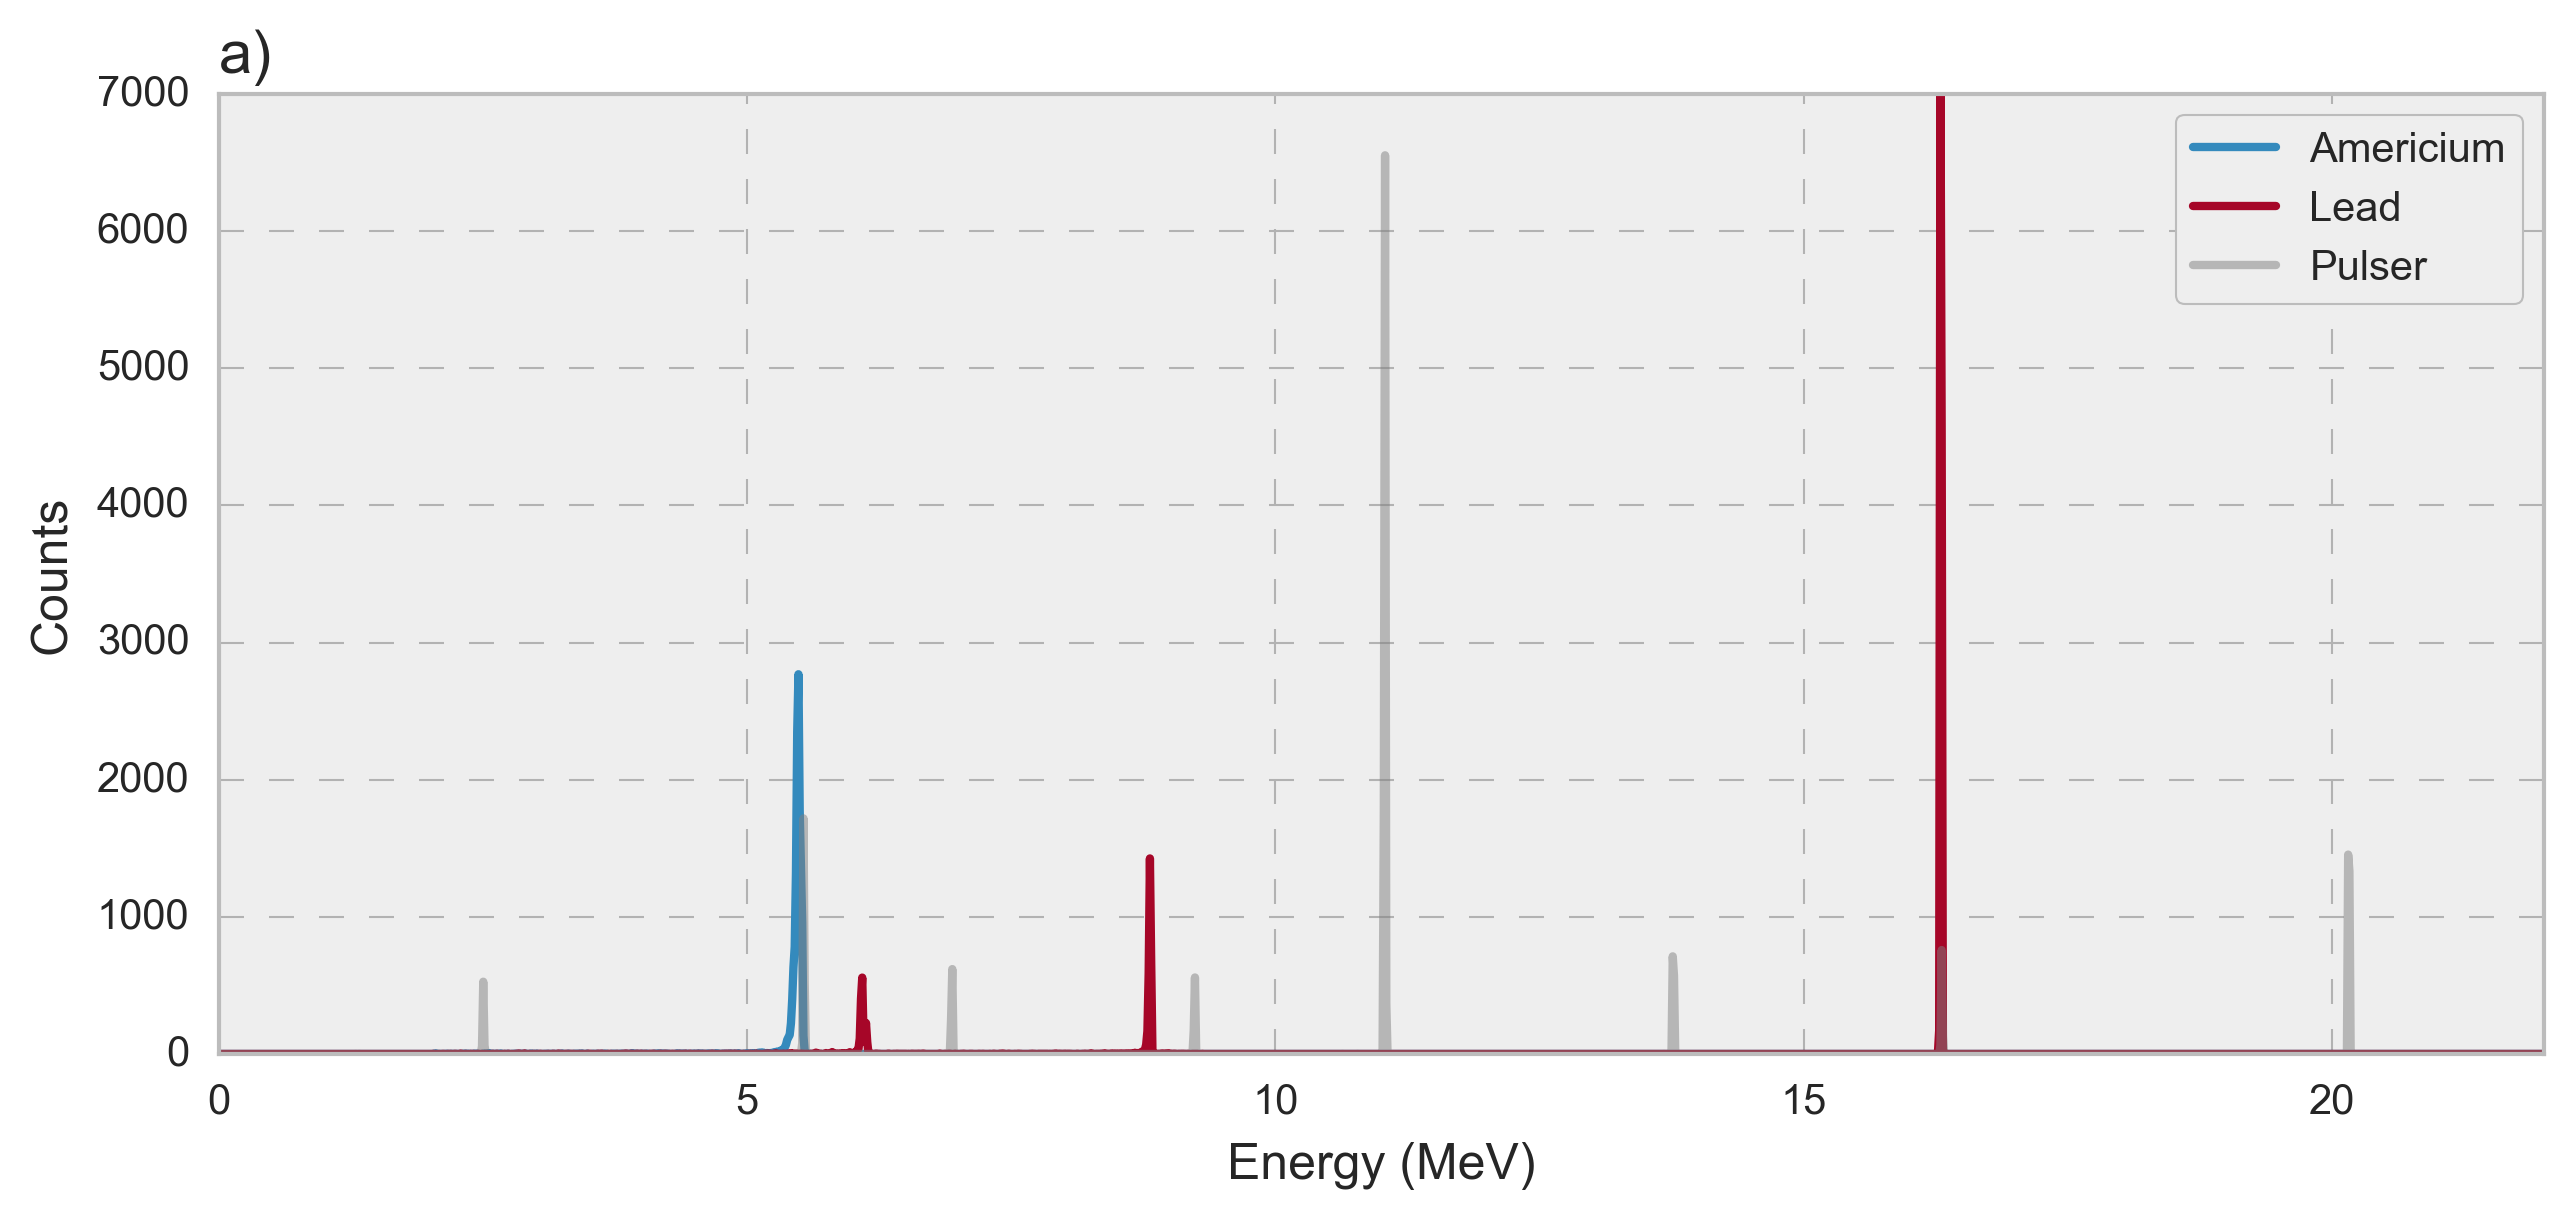

In [229]:
# plotting the spectra with our americium calibration data and the lead data 
plt.style.use('bmh')

plt.figure(figsize = (10, 4), dpi = 300)
plt.plot(energy, am_counts, label='Americium')
plt.plot(energy, pb_counts, label='Lead')
plt.plot(energy, pulser_counts, label='Pulser', color = 'grey', alpha = 0.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend( loc = 'upper right', frameon = True)
plt.xlim(0, 22)
plt.ylim(0, 7000)
plt.title('a)', loc = 'left')
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/spectra.pdf', bbox_inches='tight')

In [ ]:
# zooming in on the lead spectrum and plotting  with errors

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300, sharey=True)

# Left subplot
ax[0].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[0].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[0].errorbar(energy, am_counts, xerr=energy_err, yerr=am_counts_err, fmt='.', label='Americium', alpha=0.5, capsize=100)
ax[0].errorbar(energy, pb_counts, xerr=energy_err, yerr=pb_counts_err, fmt='.', label='Lead', alpha=0.5, capsize=100)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='upper right', frameon=True)
ax[0].set_xlim(5, 6.5)
ax[0].set_ylim(0, 1500)

# Right subplot
ax[1].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[1].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[1].errorbar(energy, am_counts, xerr=energy_err, yerr=am_counts_err, fmt='.', label='Americium', alpha=0.5, capsize=100)
ax[1].errorbar(energy, pb_counts, xerr=energy_err, yerr=pb_counts_err, fmt='.', label='Lead', alpha=0.5, capsize=100)
ax[1].set_xlabel('Energy (MeV)')
ax[1].legend(loc='upper right', frameon=True)
ax[1].set_xlim(8.5, 9.1)

plt.tight_layout()
plt.title('b)', loc = 'left')
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/zoom.pdf', bbox_inches='tight')
plt.show()